In [61]:
import matplotlib.font_manager as fm

# 利用可能な日本語フォントを確認
fonts = [f.name for f in fm.fontManager.ttflist if 'japan' in f.name.lower() or 'ipa' in f.name.lower() or 'gothic' in f.name.lower()]
print("利用可能な日本語フォント:")
print(fonts[:10])  # 最初の10個を表示

利用可能な日本語フォント:
['IPAexGothic']


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import japanize_matplotlib
from collections import Counter

# グローバルなフォント設定を強制的に適用
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['IPAexGothic', 'Yu Gothic', 'Meiryo', 'MS Gothic', 'DejaVu Sans']

In [74]:
from google.colab import files
uploaded = files.upload()

# アップロードしたファイル名を確認
import os
csv_filename = None
for filename in uploaded.keys():
    if filename.endswith('.csv'):
        csv_filename = filename
        break

if csv_filename:
    df = pd.read_csv(csv_filename, encoding='utf-8-sig')
    print(f"ファイル '{csv_filename}' を読み込みました。")
else:
    print("CSVファイルが見つかりませんでした。")

Saving sample_network_data.csv to sample_network_data (3).csv
ファイル 'sample_network_data (3).csv' を読み込みました。


In [75]:
# データの確認
print("\nデータの概要:")
print(df.head())
print(f"\nデータ件数: {len(df)}")
print(f"\n基準日別の件数:")
print(df['基準日'].value_counts())


データの概要:
          基準日   従業員ID 組織名称     送信者     受信者
0  2024-04-01  EMP001  営業部  EMP001  EMP002
1  2024-04-01  EMP002  営業部  EMP002  EMP001
2  2024-04-01  EMP001  営業部  EMP001  EMP003
3  2024-04-01  EMP003  営業部  EMP003  EMP001
4  2024-04-01  EMP001  営業部  EMP001  EMP004

データ件数: 104

基準日別の件数:
基準日
2024-10-01    68
2024-04-01    36
Name: count, dtype: int64


In [76]:
def create_network_graph(date_str, title):
    # 指定された基準日のデータを抽出
    date_df = df[df['基準日'] == date_str].copy()

    if len(date_df) == 0:
        print(f"警告: {date_str}のデータが見つかりませんでした。")
        return None

    # 有向グラフを作成
    G = nx.DiGraph()

    # 従業員IDと組織名称のマッピングを作成
    emp_dept_map = {}
    for _, row in date_df.iterrows():
        emp_id = row['従業員ID']
        dept = row['組織名称']
        emp_dept_map[emp_id] = dept

    # ノードとエッジを追加
    for _, row in date_df.iterrows():
        sender = row['送信者']
        receiver = row['受信者']
        sender_dept = row['組織名称']
        receiver_dept = emp_dept_map.get(receiver, sender_dept)

        # ノードを追加（属性として組織名称を付与）
        G.add_node(sender, department=sender_dept)
        G.add_node(receiver, department=receiver_dept)

        # エッジを追加（既存のエッジがあれば重みを増やす）
        if G.has_edge(sender, receiver):
            G[sender][receiver]['weight'] += 1
        else:
            G.add_edge(sender, receiver, weight=1)

    # レイアウトの計算
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
#    pos = nx.kamada_kawai_layout(G)

    # 組織ごとの色マッピング
    departments = set([G.nodes[node]['department'] for node in G.nodes()])
    color_map = {
        '営業部': '#FF6B6B',    # 赤
        '開発部': '#4ECDC4'    # 青緑
    }

    # ノードの色を設定
    node_colors = [color_map.get(G.nodes[node]['department'], '#CCCCCC') for node in G.nodes()]

    # ノードのサイズをコミュニケーション量（デグリー）に応じて設定
    # 有向グラフの場合、総デグリー（送信数+受信数）を使用
    degrees = dict(G.degree())
    degree_values = list(degrees.values())

    # ノードサイズをスケーリング（最小500、最大3000）
    if degree_values:
        min_degree = min(degree_values)
        max_degree = max(degree_values)
        if max_degree > min_degree:
            # 線形スケーリング
            node_sizes = [500 + (degrees[node] - min_degree) / (max_degree - min_degree) * 2500
                         for node in G.nodes()]
        else:
            # すべて同じデグリーの場合
            node_sizes = [2000] * len(G.nodes())
    else:
        node_sizes = [2000] * len(G.nodes())

    # 図のサイズを設定
    fig, ax = plt.subplots(figsize=(8, 6))

    # ノードを描画
    nx.draw_networkx_nodes(G, pos,
                          node_color=node_colors,
                          node_size=node_sizes,
                          alpha=0.9,
                          edgecolors='black',
                          linewidths=2,
                          ax=ax)

    # エッジを描画（重みに応じて太さを変える）
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]

    nx.draw_networkx_edges(G, pos,
                          edgelist=edges,
                          width=[w * 2 for w in weights],
                          alpha=0.6,
                          edge_color='gray',
                          arrows=True,
                          arrowsize=20,
                          arrowstyle='->',
                          ax=ax)

    # ラベルを描画
    labels = {node: node.replace('EMP', '') for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, ax=ax)

    # 凡例を作成
    legend_elements = [mpatches.Patch(color=color_map[dept], label=dept)
                      for dept in departments if dept in color_map]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=12, prop={'size': 12})

    # タイトルとラベル
    ax.set_title(title, fontsize=16, pad=20)
    ax.axis('off')
    plt.tight_layout()

    return G

print("可視化関数を定義しました。")

可視化関数を定義しました。


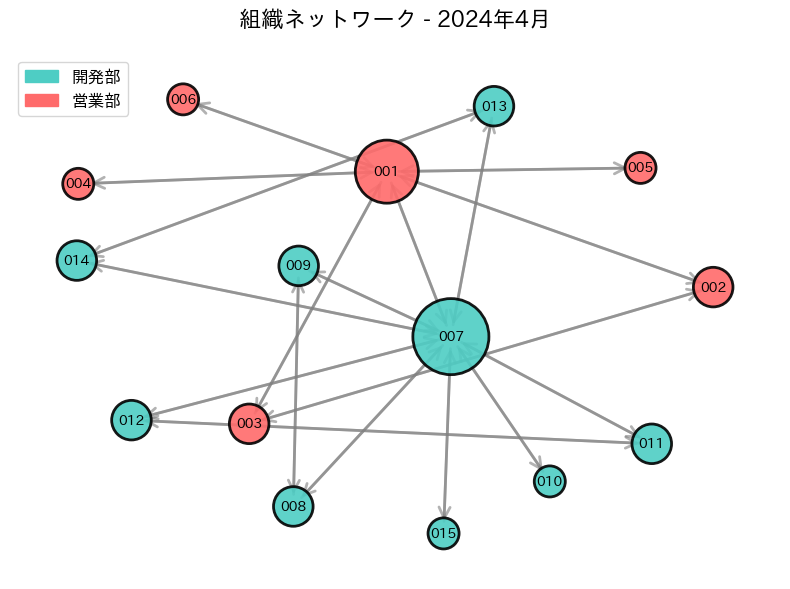

In [77]:
G_april = create_network_graph('2024-04-01', '組織ネットワーク - 2024年4月')

plt.show()

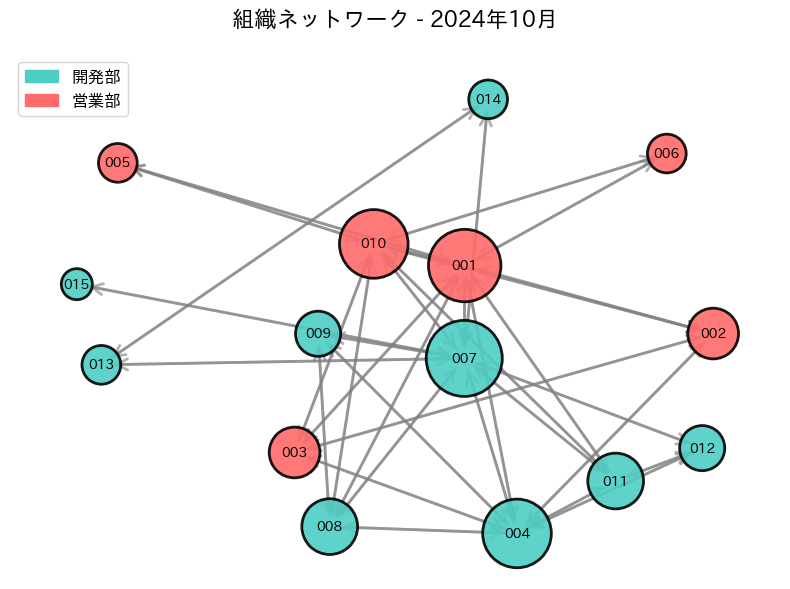

In [78]:
G_october = create_network_graph('2024-10-01', '組織ネットワーク - 2024年10月')

plt.show()

In [79]:
if G_april and G_october:
    print(f"ノード数: 4月={G_april.number_of_nodes()}, 10月={G_october.number_of_nodes()}")
    print(f"エッジ数: 4月={G_april.number_of_edges()}, 10月={G_october.number_of_edges()}")

    # 組織間のコミュニケーション分析
    def analyze_inter_department_communication(G, date_str):
        """組織間のコミュニケーションを分析"""
        print(f"\n{date_str}の組織間コミュニケーション:")
        inter_dept_edges = []
        for u, v in G.edges():
            u_dept = G.nodes[u]['department']
            v_dept = G.nodes[v]['department']
            if u_dept != v_dept:
                inter_dept_edges.append((u_dept, v_dept))

        if inter_dept_edges:
            counter = Counter(inter_dept_edges)
            for (dept1, dept2), count in counter.most_common():
                print(f"  {dept1} → {dept2}: {count}件")
        else:
            print("  組織間のコミュニケーションはありません")

    analyze_inter_department_communication(G_april, '4月')
    analyze_inter_department_communication(G_october, '10月')

ノード数: 4月=15, 10月=15
エッジ数: 4月=36, 10月=68

4月の組織間コミュニケーション:
  営業部 → 開発部: 1件
  開発部 → 営業部: 1件

10月の組織間コミュニケーション:
  営業部 → 開発部: 9件
  開発部 → 営業部: 9件


In [80]:
def calculate_betweenness_centrality(G, date_str):
    print(f"\n{date_str}の媒介中心性（高い順）:")
    betweenness_centrality = nx.betweenness_centrality(G)
    for emp, score in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True):
        dept = G.nodes[emp]['department']
        print(f"  {emp} ({dept}): {score:.3f}")

if G_april:
    calculate_betweenness_centrality(G_april, '4月')

if G_october:
    calculate_betweenness_centrality(G_october, '10月')


4月の媒介中心性（高い順）:
  EMP007 (開発部): 0.802
  EMP001 (営業部): 0.593
  EMP002 (営業部): 0.000
  EMP003 (営業部): 0.000
  EMP004 (営業部): 0.000
  EMP005 (営業部): 0.000
  EMP006 (営業部): 0.000
  EMP008 (開発部): 0.000
  EMP009 (開発部): 0.000
  EMP010 (開発部): 0.000
  EMP011 (開発部): 0.000
  EMP012 (開発部): 0.000
  EMP013 (開発部): 0.000
  EMP014 (開発部): 0.000
  EMP015 (開発部): 0.000

10月の媒介中心性（高い順）:
  EMP007 (開発部): 0.442
  EMP001 (営業部): 0.190
  EMP010 (営業部): 0.158
  EMP004 (開発部): 0.123
  EMP008 (開発部): 0.020
  EMP011 (開発部): 0.020
  EMP002 (営業部): 0.002
  EMP003 (営業部): 0.002
  EMP005 (営業部): 0.000
  EMP006 (営業部): 0.000
  EMP009 (開発部): 0.000
  EMP012 (開発部): 0.000
  EMP013 (開発部): 0.000
  EMP014 (開発部): 0.000
  EMP015 (開発部): 0.000
